<h1>
Final Porject Group 31
<h/1>

<h3>
Reading the data
<h/3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import lognorm, expon, gamma, weibull_min, kstest, probplot
from typing import List

In [2]:
df = pd.read_csv('archive/loan_sanction_train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<h3>
Cleaning the Data
<h/3>

<h4>
Removing NaN values
<h/4>

In [3]:
print(f"Dimensions of the data: {df.shape}")
total_nan = df.isnull().sum().sum()
total_nan_col = df.isnull().sum()
print(f"Number of NaN: {total_nan}", f"\nNumber of NaN per column: \n{total_nan_col}")



Dimensions of the data: (614, 13)
Number of NaN: 149 
Number of NaN per column: 
Loan_ID                0
Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount           22
Loan_Amount_Term      14
Credit_History        50
Property_Area          0
Loan_Status            0
dtype: int64


In [4]:
def plot_nan_distributions(df: pd.DataFrame) -> None:
    """
    Plots the distribution of NaN values in the columns of the dataframe.
    """

    colums_with_nan = df.columns[df.isnull().any()].tolist()

    for col in colums_with_nan:
        plt.figure(figsize=(8, 4))
        df[col].value_counts(dropna=False).plot(kind='bar')
        plt.title(f"Distribution of '{col}' (including NaN values)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


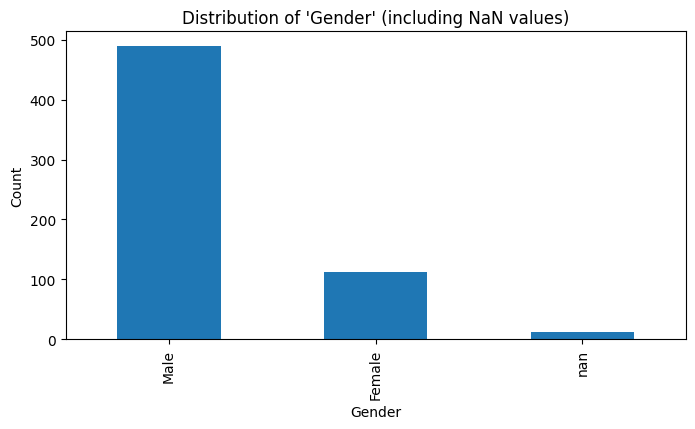

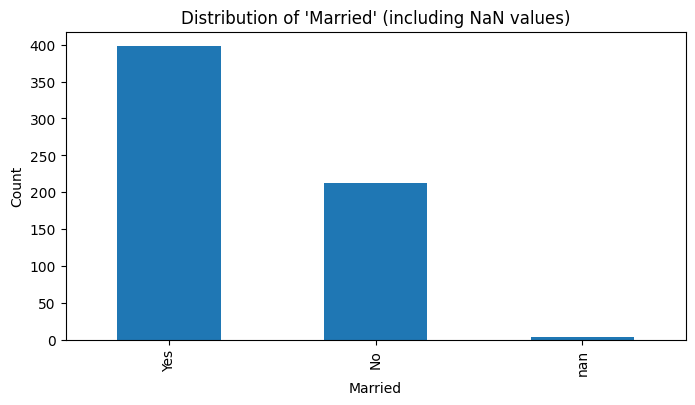

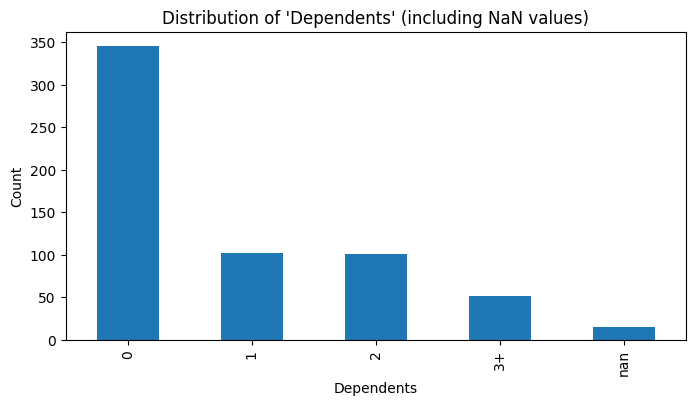

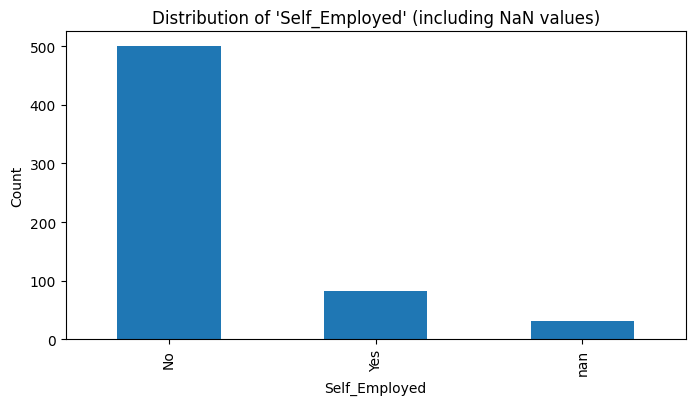

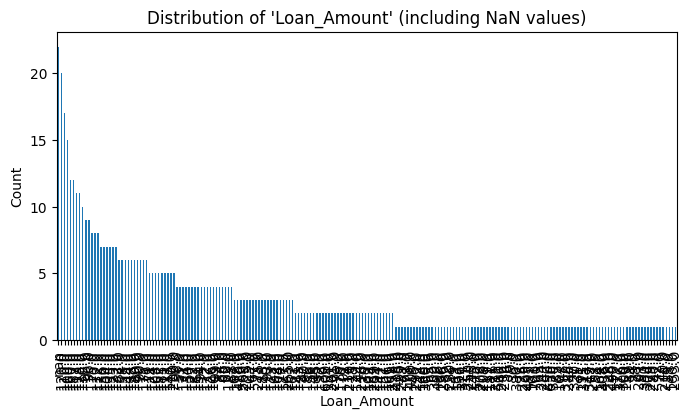

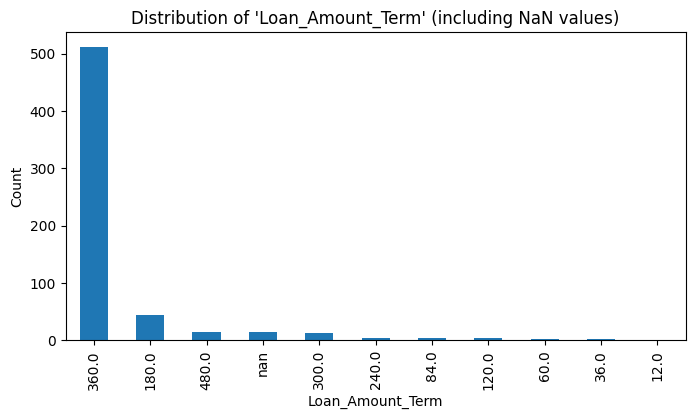

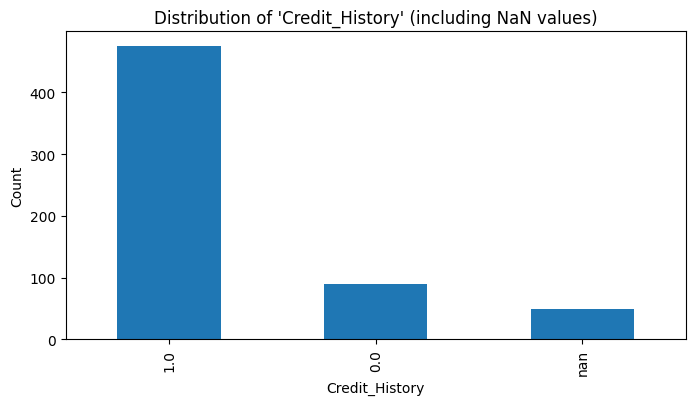

In [5]:
plot_nan_distributions(df)

<h5>
Rather than dropping all rows containing NaN values—which would remove over 100 rows from our dataset of only 614—it’s more effective to handle these values thoughtfully. Research suggests that even missing values can carry predictive weight. Instead of leaving cells empty, we’ll apply different strategies based on the data type and distribution of each column. For Credit History, where data is missing entirely, we'll set NaN values to 0. For categorical columns, where a dominant class exists, filling NaN values with the mode makes logical sense. For the Loan Amount column, which approximates an exponential distribution, using the average provides a better estimate for missing values.
<h/5>

In [6]:
def clean_data(df: pd.DataFrame, mode: List[str]) -> pd.DataFrame:
    """ 
    Clean the data by filling NaN values with the mean for 'Loan_Amount', 0 to the credit history,  and the mode for the columns in the 'mode' list.
    """

    cleaned_df = df.copy()
    cleaned_df['Credit_History'] = cleaned_df['Credit_History'].fillna(0)
    cleaned_df['Loan_Amount'] = cleaned_df['Loan_Amount'].fillna(cleaned_df['Loan_Amount'].mean())

    for col in mode:
        cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])

    return cleaned_df

In [7]:
colums_2_clean = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']

df = clean_data(df, colums_2_clean)

total_nan = df.isnull().sum().sum()
print(f"Number of NaN: {total_nan}")

df.head(10)

Number of NaN: 0


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N


<h3>
Normalizing Data
<h/3>

<h5>
the "Loan_Amount" seems to be following a exponetial decreasing,  log normal or gamma distribution. Depending on which model fits better we should normalize the data
<h/5>

In [10]:

def best_fit_distribution(df: pd.DataFrame, column:str):
    """
    Finds the best-fitting distribution for a specified column in a cleaned DataFrame.
    
    Parameters:
    df (pd.DataFrame): Cleaned DataFrame containing the data.
    column (str): Name of the column to fit distributions to.

    Returns:
    dict: Dictionary containing the name, KS statistic, p-value, and parameters of the best-fitting distribution.
    """
    # Candidate distributions to test
    distributions = {
        'Log-normal': lognorm,
        'Exponential': expon,
        'Gamma': gamma,
        'Weibull': weibull_min
        
    }

    fit_results = {}

    # Loop over distributions to fit and test
    for name, distribution in distributions.items():
        params = distribution.fit(df[column])
        d_statistic, p_value = kstest(df[column], distribution.name, args=params)
        fit_results[name] = {
            'KS Statistic': d_statistic,
            'p-value': p_value,
            'Parameters': params
        }

    # Find the best distribution based on the highest p-value
    best_fit = max(fit_results.items(), key=lambda x: x[1]['p-value'])
    best_distribution = {
        'Best Distribution': best_fit[0],
        'KS Statistic': best_fit[1]['KS Statistic'],
        'p-value': best_fit[1]['p-value'],
        'Parameters': best_fit[1]['Parameters']
    }

    print("\nDistribution Fit Results:\n")
    for dist_name, stats in fit_results.items():
        print(f"{dist_name}:")
        print(f"  KS Statistic: {stats['KS Statistic']:.4f}")
        print(f"  p-value: {stats['p-value']:.4f}")
        print(f"  Parameters: {stats['Parameters']}\n")

    # Print the best-fitting distribution in a clear format
    print("\nBest Fitting Distribution:\n")
    print(f"{best_distribution['Best Distribution']}:")
    print(f"  KS Statistic: {best_distribution['KS Statistic']:.4f}")
    print(f"  p-value: {best_distribution['p-value']:.4f}")
    print(f"  Parameters: {best_distribution['Parameters']}\n")


In [11]:
best_fit_distribution(df, 'Loan_Amount')


Distribution Fit Results:

Log-normal:
  KS Statistic: 0.0792
  p-value: 0.0008
  Parameters: (0.42475558658593976, -18.001512791270773, 149.36010312325297)

Exponential:
  KS Statistic: 0.2880
  p-value: 0.0000
  Parameters: (9.0, 137.41216216216216)

Gamma:
  KS Statistic: 0.1023
  p-value: 0.0000
  Parameters: (3.932802760014692, 3.7000664042819746, 36.28762641456209)

Weibull:
  KS Statistic: 0.1258
  p-value: 0.0000
  Parameters: (1.7815724676605398, 8.500648339178564, 155.68037885676767)


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0792
  p-value: 0.0008
  Parameters: (0.42475558658593976, -18.001512791270773, 149.36010312325297)



In [12]:
best_fit_distribution(df, 'Applicant_Income')



Distribution Fit Results:

Log-normal:
  KS Statistic: 0.0865
  p-value: 0.0002
  Parameters: (0.6218119518274026, -116.84111751508071, 4335.977983277862)

Exponential:
  KS Statistic: 0.2402
  p-value: 0.0000
  Parameters: (150.0, 5253.459283387622)

Gamma:
  KS Statistic: 0.9984
  p-value: 0.0000
  Parameters: (0.0001681481079556994, 149.99999999999997, 6.032405245872729)

Weibull:
  KS Statistic: 0.2590
  p-value: 0.0000
  Parameters: (0.8595295631466613, 149.99999999999997, 5786.706804425036)


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0865
  p-value: 0.0002
  Parameters: (0.6218119518274026, -116.84111751508071, 4335.977983277862)



In [13]:
best_fit_distribution(df, 'Coapplicant_Income')


Distribution Fit Results:

Log-normal:
  KS Statistic: 0.3665
  p-value: 0.0000
  Parameters: (373.768896303284, -5e-324, 1.2967308210834694e-142)

Exponential:
  KS Statistic: 0.4446
  p-value: 0.0000
  Parameters: (0.0, 1621.2457980271008)

Gamma:
  KS Statistic: 0.9879
  p-value: 0.0000
  Parameters: (0.00026504566778039245, -2.6419977126892273e-20, 4.333172847269802)

Weibull:
  KS Statistic: 0.4511
  p-value: 0.0000
  Parameters: (0.011547570224718494, 424.63931882833197, 2.777228468214088e-21)


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.3665
  p-value: 0.0000
  Parameters: (373.768896303284, -5e-324, 1.2967308210834694e-142)



C:\Users\joerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\joerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<h5>
Since the data in Loan_Amount is right-skewed, we found that a log-normal transformation provides the best fit. This transformation reduces the skew, making the distribution more symmetric and closer to a normal distribution. This adjustment will improve the accuracy of our analysis later on. Same applices for the application income and co-income
<h/5>

In [14]:
#Add a log-transformed version of Loan_Amount and Application Income to the DataFrame
df['Log_Amount_Log'] = np.log1p(df['Loan_Amount']) 
df['Log_Applicant_Income'] = np.log1p(df['Applicant_Income']) 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Log_Amount_Log,Log_Applicant_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,4.993232,8.674197
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,4.859812,8.430327
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,4.204693,8.006701
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4.795791,7.857094
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,4.955827,8.699681


NameError: name 'probplot' is not defined

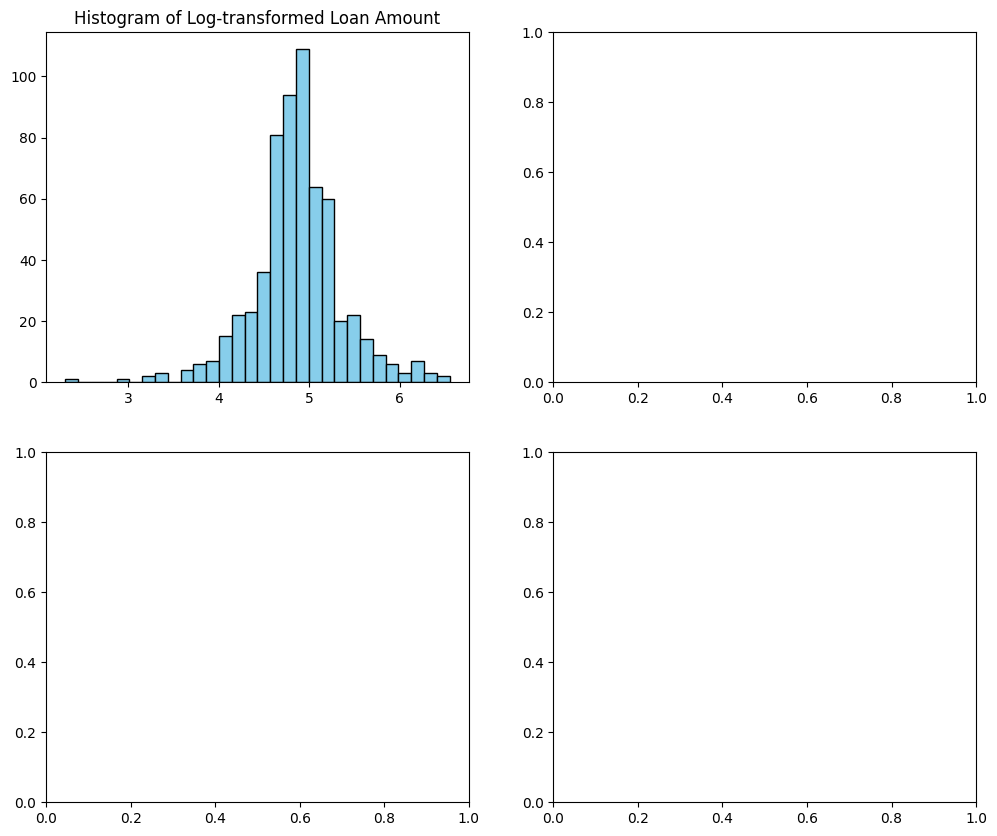

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loan Amount Log-transformed
axs[0, 0].hist(df['Log_Amount_Log'], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title("Histogram of Log-transformed Loan Amount")

probplot(df['Log_Amount_Log'], dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Q-Q Plot of Log-transformed Loan Amount")

# Applicant Income Log-transformed
axs[1, 0].hist(df['Log_Applicant_Income'], bins=30, color='lightgreen', edgecolor='black')
axs[1, 0].set_title("Histogram of Log-transformed Applicant Income")

probplot(df['Log_Applicant_Income'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot of Log-transformed Applicant Income")

plt.tight_layout()
plt.show()